In [1]:
import os
import re
import numpy as np
import pandas as pd
import sklearn
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from tensorboard.plugins.hparams import api as hp

from scipy.sparse import csr_matrix
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall
from sklearn.utils import class_weight
from tensorflow.keras.layers import LSTM,Embedding,Dense,Dropout,Bidirectional,GlobalMaxPool1D,GlobalAveragePooling1D, SpatialDropout1D

import emoji

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saumyamehta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saumyamehta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
olid_data = pd.read_csv("data/OLIDv1/olid-training-v1.0.tsv", sep='\t')


Emoji to text conversion

In [3]:
def emoji_to_text(s):
    s = emoji.demojize(s)
    s = s.replace(':',' ')
    s = s.replace('_',' ')    
    s = ' '.join(s.split())
    return s

In [4]:
# small sentence demo for emoji to text
s = '@USER He is all grown up😭😭😭'
emoji_to_text(s)

'@USER He is all grown up loudly crying face loudly crying face loudly crying face'

Twitter slang to formal text conversion

In [5]:
# loading twitter slang data
slang_df = pd.read_csv('data/twitterSlang.csv')
slang_dict = dict(zip(slang_df.slang, slang_df.formal_translation))

In [6]:
def fix_slang(s):
    s_list = s.split()
    new_s_list = []
    for word in s_list:
        if word in slang_dict.keys():
            new_s_list.append(slang_dict[word])
        else:
            new_s_list.append(word)
            
    return ' '.join(new_s_list)

In [7]:
# small example of slang removal
s = "I'll fix this asap. brb"
fix_slang(s)

"I'll fix this asap. be right back"

In [8]:
X_train = olid_data.tweet
y_train = pd.factorize(olid_data.subtask_a)[0]

X_test=pd.read_csv('data/OLIDv1/testset-levela.tsv',sep="\t").tweet
y_test=pd.read_csv( 'data/OLIDv1/labels-levela.csv',header=None).iloc[:,-1]
y_test = pd.factorize(y_test)[0]
import collections
collections.Counter(y_train)
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')


X train shape: (13240,), y train shape: (13240,)


Splitting data into train hold out sets.
Our split will be 80% train, 20% validation 

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.2, random_state=42)
# check shapes of train, test and validation data
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')
print(f'X valid shape: {X_valid.shape}, y valid shape: {y_valid.shape}')
print(f'X valid shape: {X_test.shape}, y test shape: {y_test.shape}')


X train shape: (10592,), y train shape: (10592,)
X valid shape: (2648,), y valid shape: (2648,)
X valid shape: (860,), y test shape: (860,)


Data preprocessing. 

In [10]:
def preprocess(sent, lemmatizer, stop_words):
    
    alphabet = "abcdefghijklmnopqrstuvwxyz 0123456789',."
    emojis = ''.join(c for c in sent if c in emoji.UNICODE_EMOJI['en'])
    alphabet = alphabet + emojis
    #sent = emoji_to_text(sent)
    sent = fix_slang(sent)
    sent = sent.lower()
    sent = sent.replace('@user','')
    sent = sent.replace('@[\w\-]+','')

    cleaned_sent_list = [char if char in alphabet else ' ' for char in sent] # remove all tags not in the alphabet

    cleaned_sent = ''.join(cleaned_sent_list)
    cleaned_sent_list = [lemmatizer.lemmatize(token) for token in cleaned_sent.split(" ")]
    cleaned_sent_list = [word for word in cleaned_sent_list if not word in stop_words]
    cleaned_sent = ' '.join(cleaned_sent_list)
    cleaned_sent = cleaned_sent.replace("n't",' not') # replace words like "isn't" with "is not"
    cleaned_sent = ' . '.join([x for x in cleaned_sent.split('.') if len(x)>0]) # remove multiple periods, and add spaces before and after a period
    cleaned_sent = ' , '.join([x for x in cleaned_sent.split(',') if len(x)>0]) # add spaces before and after a comma
    cleaned_sent = ' '.join(cleaned_sent.split()) # remove multiple spaces
    
    return cleaned_sent

In [11]:

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()
data_train = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_train]
data_valid = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_valid]
data_test = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_test]

Emoji and twitter slang

In [12]:
data_train[20], data_valid[0], data_test[0]

('😂🤣😂🤣😂👍👌 thats good one . never knew antifa badasses . 😂😂😂😂👍 need comedy special 🤣😂🤣😂',
 'john kerry running mouth cared ha say think single damn thing kerry ha accomplished besides run mouth . trump accomplishment exceed anything kerry could ever dream of . even becoming president',
 'whoisq wherestheserver dumpnike declasfisa democrat support antifa , muslim brotherhood , ms13 , isis , pedophilia , child trafficking , taxpayer funded abortion s , election fraud , sedition treason lockthemallup wwg1wga qanon url')

In [13]:
vocab_size = 10000
embedding_size = 300
lstm_output_dim = 32
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

Tokenisation and padding for sentences


In [14]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data_train)
word2int = tokenizer.word_index
print(word2int)


5891, 'midterms2018': 15892, '1ab': 15893, 'usmc': 15894, 'navy': 15895, 'airforce': 15896, 'jealousy': 15897, 'favored': 15898, 'victimhood': 15899, 'parlaying': 15900, 'bnp': 15901, 'somerset': 15902, 'chester': 15903, 'burnley': 15904, 'halifax': 15905, 'invert': 15906, 'urself': 15907, 'sequel': 15908, 'dceu': 15909, 'irreversibly': 15910, 'yyyy': 15911, 'steepppp': 15912, 'themfaux': 15913, 'tainted': 15914, 'noise': 15915, 'adviser': 15916, 'discouraging': 15917, 'miller👌': 15918, 'steps': 15919, "'out'": 15920, "'info'": 15921, 'actualy': 15922, 'becareful': 15923, 'sooooo': 15924, 'appropo': 15925, 'impart': 15926, 'selfies': 15927, 'ousted': 15928, 'resulting': 15929, 'disguise': 15930, 'stylistic': 15931, 'prioritise': 15932, 'discretion': 15933, 'ambiguity': 15934, 'shocktroops': 15935, 'francisco': 15936, 'pleasant': 15937, 'frend': 15938, 'yoll': 15939, 'torn': 15940, 'consternation': 15941, 'mccaskill': 15942, 'squabbles': 15943, 'foulmouthed': 15944, 'rapper': 15945, 'am

In [15]:
train_sequences = tokenizer.texts_to_sequences(data_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

valid_sequences = tokenizer.texts_to_sequences(data_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



# Glove Embeddings
References: https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html

In [16]:
glove_path = "embeddings/glove.840B.300d.txt"

In [17]:
def get_word_vectors(word, *arr):
    return word, np.array(arr, dtype = 'float32')

In [18]:
def build_embedddings(embedding_path, word2int):
    embeddings = dict(get_word_vectors(*x.strip().split(" ")) for x in open(embedding_path))

    nwords = min(vocab_size, len(word2int))
    embedding_matrix = np.zeros((nwords, embedding_size))

    for word, index in word2int.items():
        if index >=vocab_size:
            continue

        embedding_vec = embeddings.get(word)
        if embedding_vec is not None:
            embedding_matrix[index] = embedding_vec

    return embedding_matrix




In [19]:
glove_embeddings = build_embedddings(glove_path, word2int)

In [20]:
print(glove_embeddings.shape)

(10000, 300)


# Emoji Embeddings

In [21]:
# emoji embedding
emoji_embed_path = "embeddings/emoji2vec.txt"


In [22]:
emoji_embed_index = {}
f = open(os.path.join(emoji_embed_path))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    emoji_embed_index[word] = coefs
f.close()

nwords = min(vocab_size, len(word2int))

emoji_embeddings = np.zeros((nwords, 300))
for word, i in word2int.items():
    if i >=vocab_size:
        continue
    embedding_vector = emoji_embed_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        emoji_embeddings[i] = embedding_vector

In [23]:
emoji_embeddings.shape
emoji_embeddings[20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [24]:
# combine embeddings globve and emoji

# 1. concat
concat_embed = np.hstack((glove_embeddings,emoji_embeddings))
# 2. sum
sum_embed = np.sum((glove_embeddings,emoji_embeddings),axis=0)
# 3. mean
mean_embed = np.mean((glove_embeddings,emoji_embeddings),axis=0)
print(mean_embed.shape)

(10000, 300)


# Building the model

RNN architecture: Embedding layer of size 300 -> lstm layer with output of 32 dimension -> linear layer activated by relu -> softmax to get probability 

In [71]:
# compute class weights : "https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html"
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights


{0: 1.5196556671449069, 1: 0.7451808076544252}

Hyperparameter tuning

In [98]:
# Training loop and early stopping 

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",mode="auto", patience = 5, restore_best_weights=True)
n_epochs = 25

In [133]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(
    vocab_size, mean_embed.shape[1], 
    embeddings_initializer=tf.keras.initializers.Constant(mean_embed),
    input_length=max_length,trainable=True))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences = True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(30, return_sequences = True)))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(20, activation="relu"))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [134]:
model_trained = model.fit(train_padded, y_train, batch_size=128, epochs = n_epochs, 
verbose=2, class_weight=class_weights,validation_data=(valid_padded, y_valid), callbacks = [callbacks])

Epoch 1/25
83/83 - 30s - loss: 0.5600 - accuracy: 0.7314 - val_loss: 0.5208 - val_accuracy: 0.7492
Epoch 2/25
83/83 - 28s - loss: 0.4267 - accuracy: 0.8062 - val_loss: 0.5291 - val_accuracy: 0.7474
Epoch 3/25
83/83 - 29s - loss: 0.3250 - accuracy: 0.8608 - val_loss: 0.5747 - val_accuracy: 0.7289
Epoch 4/25
83/83 - 29s - loss: 0.2271 - accuracy: 0.9087 - val_loss: 0.7098 - val_accuracy: 0.7194
Epoch 5/25
83/83 - 27s - loss: 0.1567 - accuracy: 0.9418 - val_loss: 0.8033 - val_accuracy: 0.7100
Epoch 6/25
83/83 - 30s - loss: 0.1156 - accuracy: 0.9566 - val_loss: 1.0053 - val_accuracy: 0.7338


In [135]:
test_sequences = tokenizer.texts_to_sequences(data_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [136]:
model_trained.history

{'loss': [0.5600260496139526,
  0.4266837239265442,
  0.3250073790550232,
  0.22713777422904968,
  0.15667849779129028,
  0.11559668928384781],
 'accuracy': [0.7314010858535767,
  0.8061744570732117,
  0.8608383536338806,
  0.9087046980857849,
  0.9418429136276245,
  0.9565709829330444],
 'val_loss': [0.5207844972610474,
  0.5291174650192261,
  0.5747355818748474,
  0.7098137736320496,
  0.8033472895622253,
  1.005258560180664],
 'val_accuracy': [0.7492446899414062,
  0.7473564743995667,
  0.7288519740104675,
  0.7194108963012695,
  0.7099697589874268,
  0.7337613105773926]}

Text(0, 0.5, 'Accuracy')

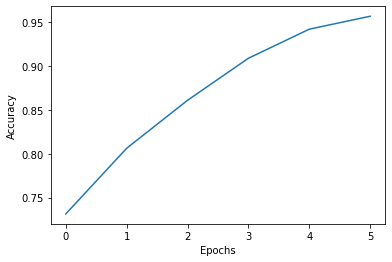

In [137]:
# PLotting accuracy of train
import matplotlib.pyplot as plt
plt.plot(model_trained.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Validation Accuracy')

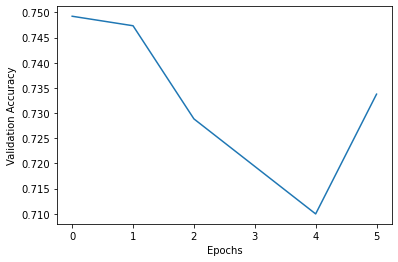

In [138]:
# PLotting accuracy of train
import matplotlib.pyplot as plt
plt.plot(model_trained.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

In [139]:

print(model.evaluate(test_padded,y_test))


27/27 [==============================] - 1s 36ms/step - loss: 0.4698 - accuracy: 0.7872
[0.4698282778263092, 0.7872093319892883]


In [140]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_padded, batch_size=128, verbose=1)
#y_pred_bool = np.argmax(y_pred, axis=1)
y_pred = (y_pred>0.5)
print(classification_report(y_test, y_pred))

7/7 [==============================] - 1s 98ms/step
              precision    recall  f1-score   support

           0       0.59      0.75      0.66       240
           1       0.89      0.80      0.84       620

    accuracy                           0.79       860
   macro avg       0.74      0.77      0.75       860
weighted avg       0.81      0.79      0.79       860



# Saving model

In [141]:
model.save("models/bigrugloveemoji.h5")

In [132]:
m = tf.keras.models.load_model("models/bigrugloveemoji.h5")
m.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 300)          3000000   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 200, 128)          140544    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 200, 60)           28800     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 60)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 100)               6100      
_________________________________________________________________
dense_34 (Dense)             (None, 20)                2020      
_________________________________________________________________
dropout_11 (Dropout)         (None, 20)              